In [3]:
import dicom
import matplotlib.pyplot as plt

%matplotlib inline

from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd

Using TensorFlow backend.


In [4]:
dicom_files = [x for x in Path('./torso/rfmri/MR').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)

pig0 = dicom.read_file(str(dicom_files[22]), force=True)
im = pig0.pixel_array

In [5]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, depth, height, width]

all_data = np.zeros((120, 47, im.shape[0], im.shape[1]))

for f in tqdm_notebook(dicom_files):
    pigfile = dicom.read_file(str(f), force=True)
    
    try:
    
        time = (pigfile.InstanceNumber - 1) // 47
        depth = pigfile.InStackPositionNumber - 1


        if np.count_nonzero(all_data[time, depth]) > 0:
            print('repeated stack position @ time %d , depth %d' % (time, depth))

        all_data[time, depth, ...] = pigfile.pixel_array
    except:
        print(f)
    

Widget Javascript not detected.  It may not be installed or enabled properly.


In [6]:
assert all_data.shape == (120, 47, 128, 128) # basic sanity check

In [7]:
import scipy.stats

scipy.stats.describe(all_data[0].flat)

DescribeResult(nobs=770048, minmax=(0.0, 5599.0), mean=377.42074000581783, variance=150212.03951245255, skewness=2.1149271851111107, kurtosis=5.985433753819269)

In [8]:
# use annotation to select pixels from volume
binary_mask = io.imread('./t0_bin_segment_v1.tif')
indices = np.nonzero(binary_mask)
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['depth', 'row', 'col'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    d, r, c = triple
    trace = all_data[:, d, r, c]
    series_df.loc[triple] = trace
    
data_block = np.vstack(series_df.values)[..., np.newaxis]
shuffled_data = np.copy(data_block)
np.random.shuffle(shuffled_data)
validation_set = shuffled_data[:1000]

Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
from keras.models import load_model
m = load_model('e8_model.h5')

m.evaluate(validation_set, validation_set)

 992/1000 [============================>.] - ETA: 0s

3049.14039453125

Tensor("conv1d_2/add:0", shape=(?, 120, 64), dtype=float32)


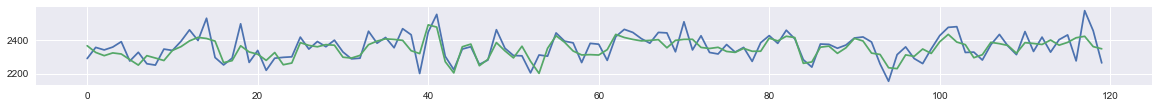

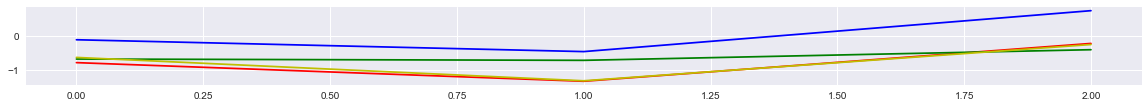

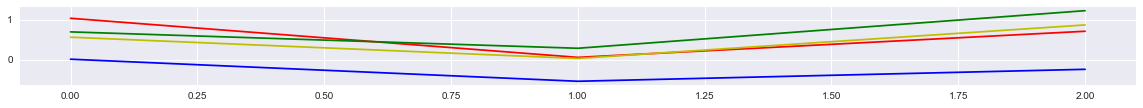

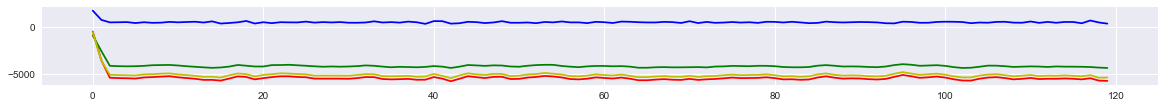

In [10]:
from keras import backend as K
layer = m.get_layer(index=1)

sample_1 = data_block[np.newaxis, 1000]
recon_1 = m.predict(sample_1)

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(recon_1))

weight_1 = layer.get_weights()[0][0][0]
weight_2 = layer.get_weights()[0][1][0]
weight_3 = layer.get_weights()[0][2][0]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot([weight_1[0], weight_2[0], weight_3[0]], c='r')
plt.plot([weight_1[1], weight_2[1], weight_3[1]], c='g')
plt.plot([weight_1[2], weight_2[2], weight_3[2]], c='b')
plt.plot([weight_1[3], weight_2[3], weight_3[3]], c='y')

layer2 = m.get_layer(index=4)

weight_1 = layer2.get_weights()[0][0][0]
weight_2 = layer2.get_weights()[0][1][0]
weight_3 = layer2.get_weights()[0][2][0]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot([weight_1[0], weight_2[0], weight_3[0]], c='r')
plt.plot([weight_1[1], weight_2[1], weight_3[1]], c='g')
plt.plot([weight_1[2], weight_2[2], weight_3[2]], c='b')
plt.plot([weight_1[3], weight_2[3], weight_3[3]], c='y')


remember_output = layer2.output
output_1 = m.predict(sample_1)
print(remember_output)

get_4th_layer_output = K.function([m.get_layer(index=0).input, K.learning_phase()],
                                  [m.get_layer(index=1).output])
layer_output = get_4th_layer_output([sample_1, 0])[0]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(layer_output[0,:,0], c='r')
plt.plot(layer_output[0,:,1], c='g')
plt.plot(layer_output[0,:,2], c='b')
plt.plot(layer_output[0,:,3], c='y')


(2000, 15, 256)
(2000, 3840)


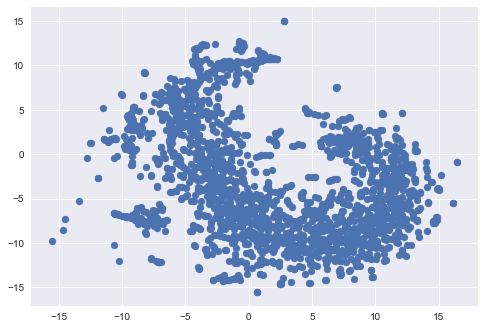

In [11]:
from sklearn import manifold
from time import time

embedding_model = keras.models.Model(inputs=m.input,
                                 outputs=m.layers[14].output)
embeddings = embedding_model.predict(data_block[:2000])
squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

print(embeddings.shape)
print(squished_embeddings.shape)

tsne_50 = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=50)
tsne_50_result = tsne_50.fit_transform(squished_embeddings)
plt.scatter(tsne_50_result[:, 0], tsne_50_result[:, 1])


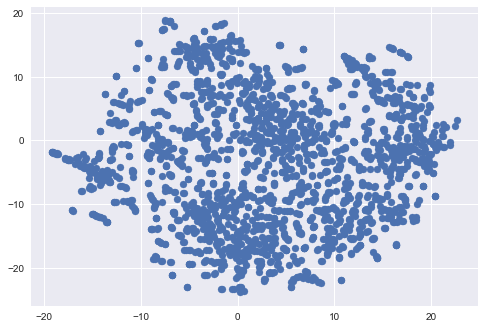

In [12]:
tsne_10 = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=10)
tsne_10_result = tsne_10.fit_transform(squished_embeddings)
plt.scatter(tsne_10_result[:, 0], tsne_10_result[:, 1])


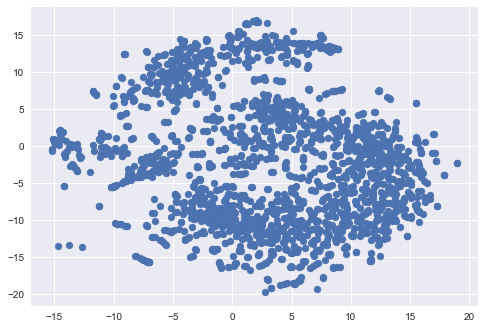

In [13]:
tsne_25 = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=25)
tsne_25_result = tsne_25.fit_transform(squished_embeddings)
plt.scatter(tsne_25_result[:, 0], tsne_25_result[:, 1])

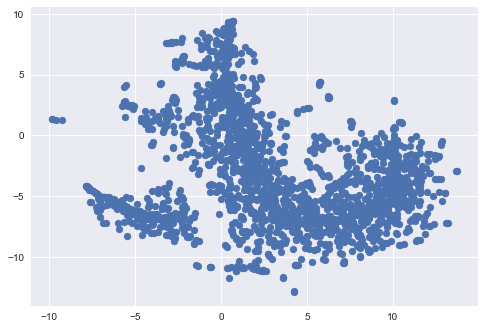

In [14]:
tsne_100 = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=100)
tsne_100_result = tsne_100.fit_transform(squished_embeddings)
plt.scatter(tsne_100_result[:, 0], tsne_100_result[:, 1])

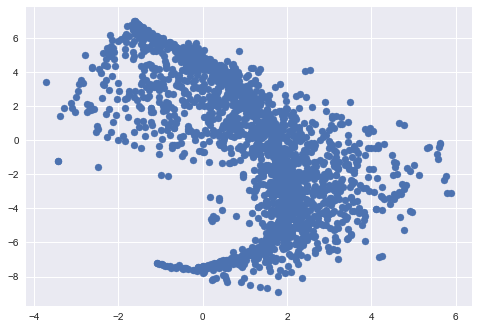

In [15]:

tsne_500 = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=500)
tsne_500_result = tsne_500.fit_transform(squished_embeddings)
plt.scatter(tsne_500_result[:, 0], tsne_500_result[:, 1])

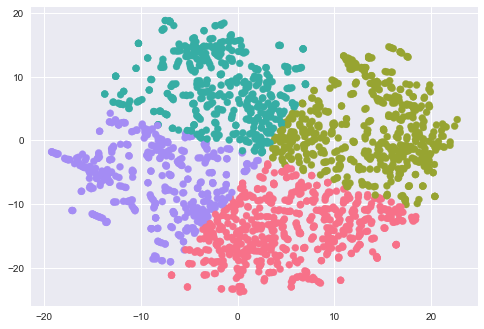

In [16]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(tsne_10_result)
labels = my_kmeans.labels_
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_10_result[:, 0], tsne_10_result[:, 1], c=colors)



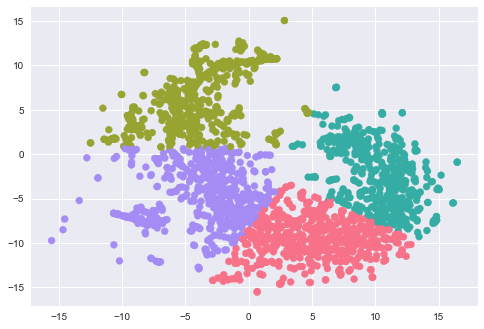

In [17]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(tsne_50_result)
labels = my_kmeans.labels_
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_50_result[:, 0], tsne_50_result[:, 1], c=colors)


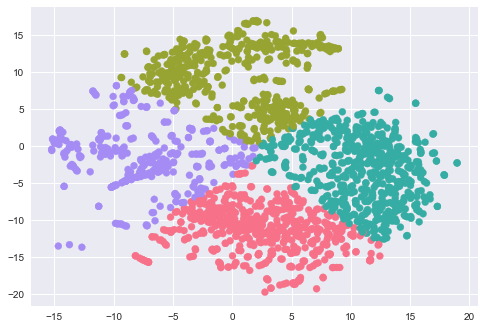

In [18]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(tsne_25_result)
labels = my_kmeans.labels_
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_25_result[:, 0], tsne_25_result[:, 1], c=colors)


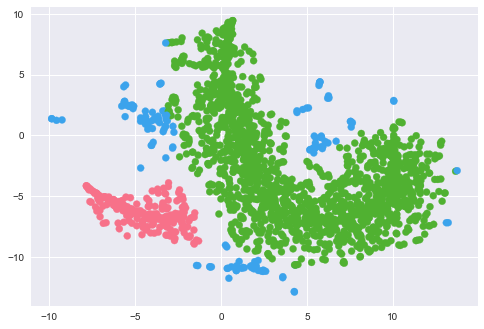

In [21]:
# color (kmeans) and label
from sklearn.cluster import KMeans, DBSCAN

db = DBSCAN(eps=2,min_samples=100)
db.fit_predict(tsne_100_result)
labels = db.labels_
rgbs = [np.array(c) for c in sns.color_palette("husl", len(np.unique(labels)))]
colors = [rgbs[i] for i in labels]


# qualitative_clusters = 2
# my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)
# my_kmeans.fit(tsne_100_result)
# labels = my_kmeans.labels_

plt.scatter(tsne_100_result[:, 0], tsne_100_result[:, 1], c=colors)


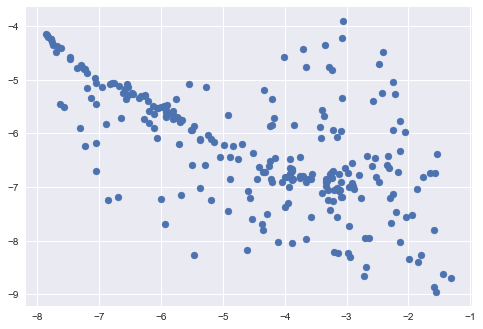

In [28]:
small_island = tsne_100_result[labels == 0]
plt.scatter(small_island[:,0], small_island[:,1])

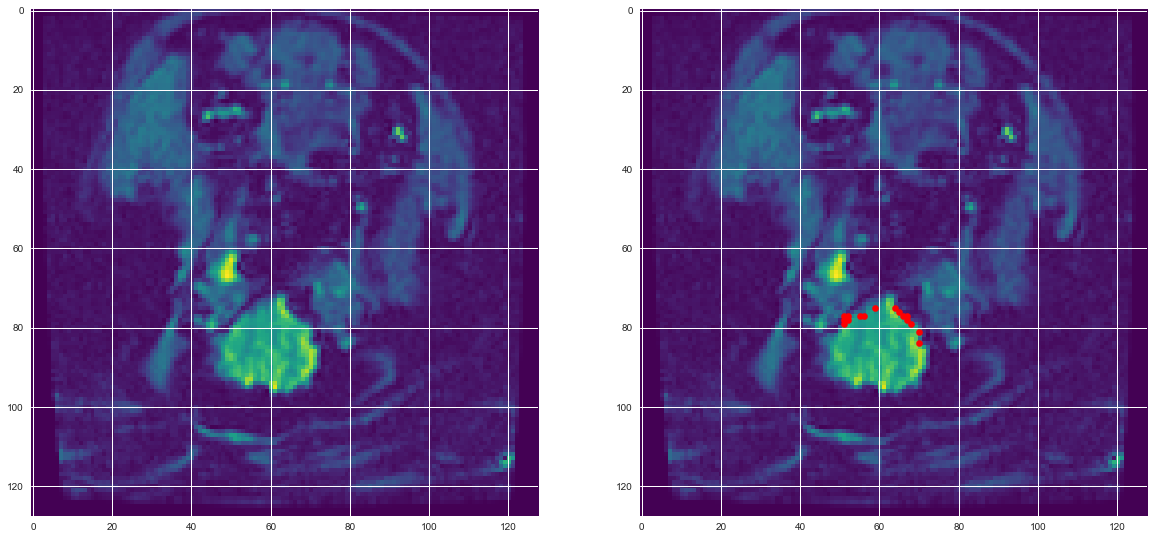

In [58]:
slice_i = 13
plt.figure(figsize=(20,10))
small_island_indices = series_df.index[:2000][labels == 0]
plt.subplot(1, 2, 1)
plt.imshow(all_data[0, slice_i], cmap='viridis')

plt.subplot(1, 2, 2)
plt.imshow(all_data[0, slice_i], cmap='viridis')
for p in small_island_indices:
    if p[0] == slice_i:
        pass
        plt.scatter(x=p[2], y=p[1], c='r', s=40)


In [103]:
print(np.unique(labels))
print(len(np.unique(labels)))

[-1  0]
2


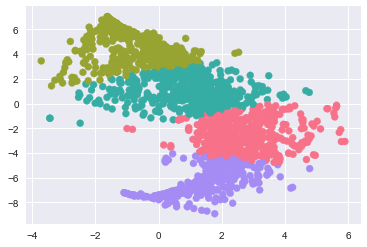

In [96]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(tsne_500_result)
labels = my_kmeans.labels_
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_500_result[:, 0], tsne_500_result[:, 1], c=colors)


In [79]:
indices_for_group_1 = np.where(labels == 1)[0]
indices_for_group_2 = np.where(labels == 2)[0]
indices_for_group_3 = np.where(labels == 3)[0]